# Transition Times in the SoG

In [1]:
import cmocean.cm as cm
import copy
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import cmocean.cm as cm
#
from Calculations_Functions import proportions_from_filename, metrics_table
from matplotlib.colors import ListedColormap
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
mask = xr.open_dataset('/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc')

In [2]:
#filename = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Simulations_runs/PBDE_particles_for_0112022_run_365_days_full_release_run_tau_0_01_ratio_0_2_sv_5_AD_0_052.zarr'
#filename2 = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Simulations_runs/RESTART_runs/PBDE_particles_for_0112022_run_365_days_full_release_run_tau_0_01_ratio_0_2_sv_5_AD_0_052_restart_365_days_2nd_year_after_full_release.zarr'
#
filename1 = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Simulations_runs/PBDE_particles_for_0112018_run_365_days_full_release_export_kernels_added.zarr'
filename2 = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Simulations_runs/RESTART_runs/PBDE_particles_for_0112018_run_365_days_full_release_export_kernels_added_restart_365_days_no_release_1_year.zarr'

In [3]:
vars_to_keep = ['trajectory', 'obs', 'lon', 'lat', 'z', 'time', 'status']
#
data = xr.open_dataset(filename1, engine = 'zarr', drop_variables=[v for v in xr.open_dataset(filename1, engine = 'zarr').variables if v not in vars_to_keep])
data2 = xr.open_dataset(filename2, engine = 'zarr', drop_variables=[v for v in xr.open_dataset(filename2, engine = 'zarr').variables if v not in vars_to_keep])

In [4]:
data_combined = xr.concat([data, data2], dim='obs' )

**Particles released in January**

In [5]:
idx_JFM = int((90 * 86400) / 900)
idx_AMJ = int((181 * 86400) / 900)
idx_JAS = int((273 * 86400) / 900)
idx_OND = int((365 * 86400) / 900)

In [6]:
particles_JAN_FEB_MAR = data_combined.isel(trajectory=slice(0, idx_JFM))
particles_APR_MAY_JUN = data_combined.isel(trajectory=slice(idx_JFM, idx_AMJ))
particles_JUL_AUG_SEP = data_combined.isel(trajectory=slice(idx_AMJ, idx_JAS))
particles_OCT_NOV_DEC = data_combined.isel(trajectory=slice(idx_JAS, idx_OND))

In [7]:
def proportions(data):
    colloidal_water = []
    marine_water = [] 
    sewage_water = []
    initial = []
    colloidal_sediment = []
    marine_sediment = []
    sewage_sediment = []
    particles_out_jdf = []
    particles_out_js = []
    total = []

    for i in range(len(data.obs)):
        status_i = data.status[:, i].values
        lat_i = data.lat[:, i].values
        lon_i = data.lon[:, i].values

        # Mask to keep only rows without NaNs
        valid_mask = (
            np.isfinite(status_i) &
            np.isfinite(lat_i) &
            np.isfinite(lon_i)
        )
        status_i = status_i[valid_mask]
        lat_i = lat_i[valid_mask]
        lon_i = lon_i[valid_mask]

        # Total valid particles
        len_T = len(status_i)

        if len_T == 0:
            # Append NaNs if no data for this time step
            initial.append(np.nan)
            colloidal_water.append(np.nan)
            marine_water.append(np.nan)
            sewage_water.append(np.nan)
            colloidal_sediment.append(np.nan)
            marine_sediment.append(np.nan)
            sewage_sediment.append(np.nan)
            particles_out_jdf.append(np.nan)
            particles_out_js.append(np.nan)
            total.append(0)
            continue

        # Counts by status
        len_initial = np.count_nonzero(status_i < 0)
        len_1 = np.count_nonzero(status_i == 1)
        len_2 = np.count_nonzero(status_i == 2)
        len_3 = np.count_nonzero(status_i == 3)
        len_11 = np.count_nonzero(status_i == 11)
        len_12 = np.count_nonzero(status_i == 12)
        len_13 = np.count_nonzero(status_i == 13)

        # Location counts
        len_jdf = np.count_nonzero((lat_i < 48.7) & (lon_i < -124.66))
        len_js = np.count_nonzero(lon_i < -126)

        # Append results
        initial.append(len_initial)
        colloidal_water.append(len_2)
        marine_water.append(len_3) 
        sewage_water.append(len_1)
        colloidal_sediment.append(len_12)
        marine_sediment.append(len_13)
        sewage_sediment.append(len_11)
        particles_out_jdf.append(len_jdf)
        particles_out_js.append(len_js)    
        total.append(len_T)

    total_arr = np.array(total, dtype=float)

    # Avoid divide-by-zero: will give NaN where total_arr == 0
    proportion_initial = np.array(initial, dtype=float)# / total_arr
    p_colloidal_water = np.array(colloidal_water, dtype=float)# / total_arr
    p_marine_water = np.array(marine_water, dtype=float)# / total_arr
    p_sewage_water = np.array(sewage_water, dtype=float)# / total_arr
    p_colloidal_sediment = np.array(colloidal_sediment, dtype=float)# / total_arr
    p_marine_sediment = np.array(marine_sediment, dtype=float)# / total_arr
    p_sewage_sediment = np.array(sewage_sediment, dtype=float)# / total_arr
    p_out_jdf = np.array(particles_out_jdf, dtype=float)# / total_arr
    p_out_js = np.array(particles_out_js, dtype=float)# / total_arr

    data_array = np.column_stack([
        proportion_initial,# * 100,
        p_colloidal_water,# * 100,
        p_marine_water,# * 100,
        p_sewage_water,# * 100,
        p_colloidal_sediment,# * 100,
        p_marine_sediment,# * 100,
        p_sewage_sediment,# * 100,
        p_out_jdf,# * 100,
        p_out_js,# * 100,
        #total_arr
    ])

    data_proportions = pd.DataFrame(
        data=data_array,
        columns=[
            'initial',
            'colloidal_water',
            'marine_water',
            'sewage_water',
            'colloidal_sediment',
            'marine_sediment',
            'sewage_sediment',
            'out_jdf',
            'out_js',
            #'total_len'
        ]
    )

    return data_proportions


In [8]:
p_particles_JFM = proportions(particles_JAN_FEB_MAR)
p_particles_AMJ = proportions(particles_APR_MAY_JUN)
p_particles_JAS = proportions(particles_JUL_AUG_SEP)
p_particles_OND = proportions(particles_OCT_NOV_DEC)

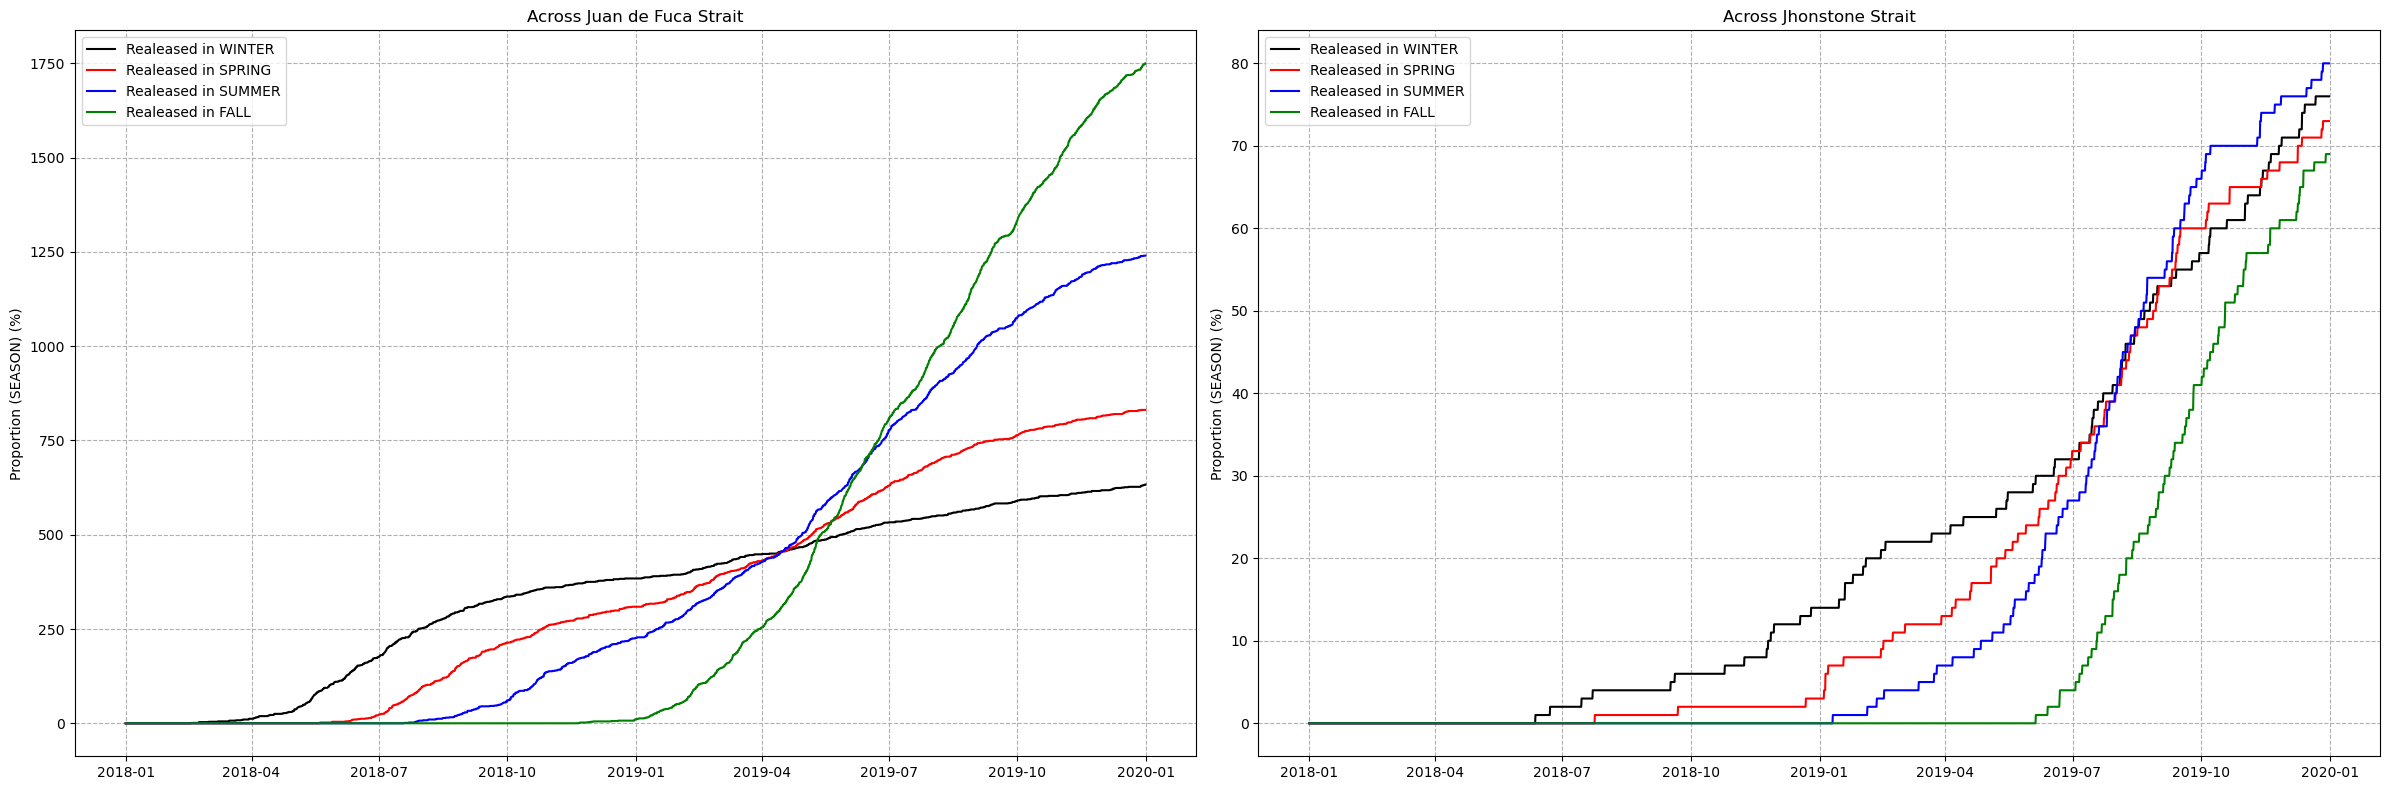

In [9]:
fig, ax = plt.subplots(1,2, figsize = (24, 8))
ax[0].plot(data_combined.time[0], p_particles_JFM['out_jdf'], 'k', label = 'Realeased in WINTER')
ax[1].plot(data_combined.time[0], p_particles_JFM['out_js'], 'k', label = 'Realeased in WINTER')
#
ax[0].plot(data_combined.time[0], p_particles_AMJ['out_jdf'], 'r', label = 'Realeased in SPRING')
ax[1].plot(data_combined.time[0], p_particles_AMJ['out_js'], 'r', label = 'Realeased in SPRING')
#
ax[0].plot(data_combined.time[0], p_particles_JAS['out_jdf'], 'b', label = 'Realeased in SUMMER')
ax[1].plot(data_combined.time[0], p_particles_JAS['out_js'], 'b', label = 'Realeased in SUMMER')
#
ax[0].plot(data_combined.time[0], p_particles_OND['out_jdf'], 'g', label = 'Realeased in FALL')
ax[1].plot(data_combined.time[0], p_particles_OND['out_js'], 'g', label = 'Realeased in FALL')
#
ax[0].legend()
ax[1].legend()
#
ax[0].set_title('Across Juan de Fuca Strait')
ax[1].set_title('Across Jhonstone Strait')
#
ax[0].set_ylabel('Proportion (SEASON) (%)')
ax[1].set_ylabel('Proportion (SEASON) (%)')
#
ax[0].grid(linestyle = '--');ax[1].grid(linestyle = '--')
#
plt.tight_layout()


Proportions are in relation to the amount of particles released at that Season

Without Seasons :D

In [10]:
p_data_combined = proportions(data_combined)

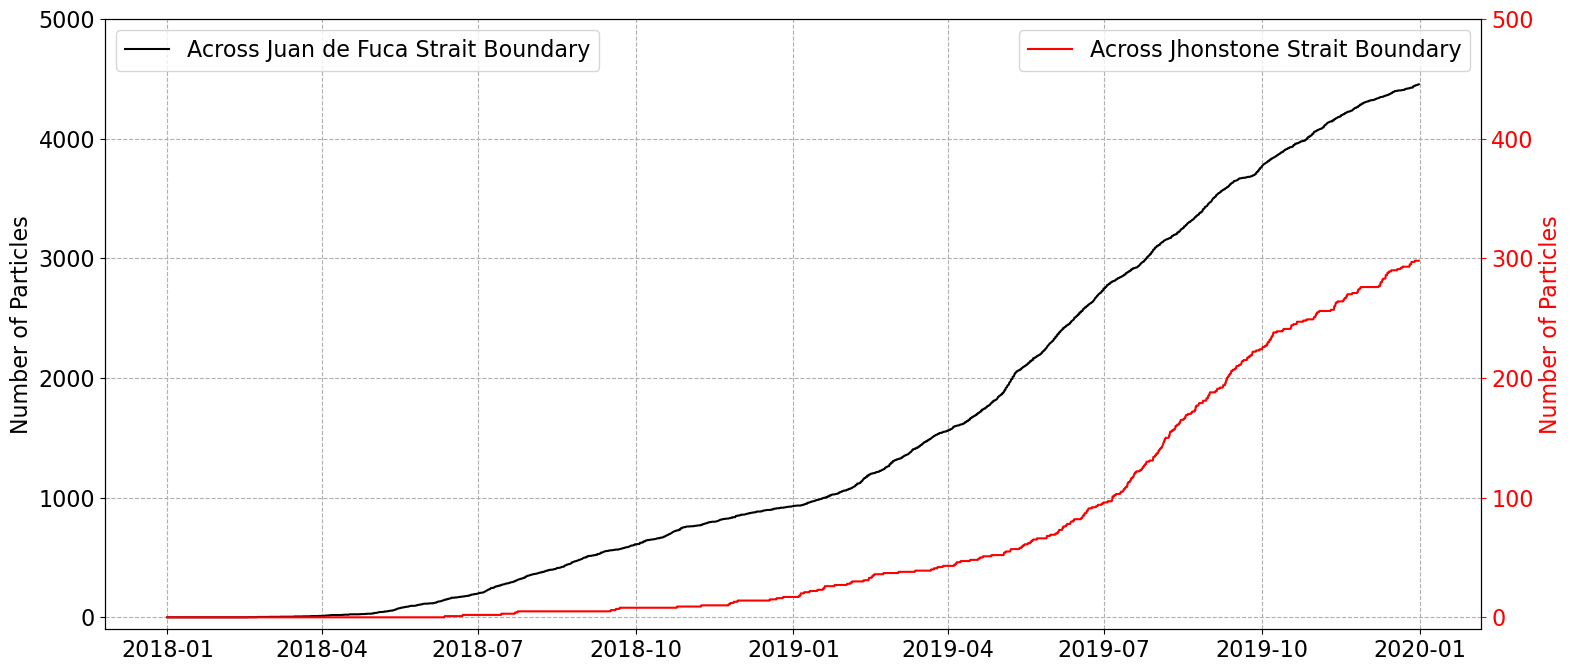

In [11]:
plt.rcParams.update({'font.size': 16})
#
fig, ax = plt.subplots(figsize = (16, 7))
ax.plot(data_combined.time[0], p_data_combined['out_jdf'], 'k', label = 'Across Juan de Fuca Strait Boundary')
axis = ax.twinx()
axis.plot(data_combined.time[0], p_data_combined['out_js'], 'r', label = 'Across Jhonstone Strait Boundary')
axis.tick_params(axis='y', colors='red')
#
ax.legend(loc = 'upper left')
axis.legend(loc = 'upper right')

#
ax.set_ylabel('Number of Particles')
axis.set_ylabel('Number of Particles', color="red")
#
ax.grid(linestyle = '--')
ax.set_ylim([-100, 5000])
axis.set_ylim([-10, 500])
#
plt.tight_layout()

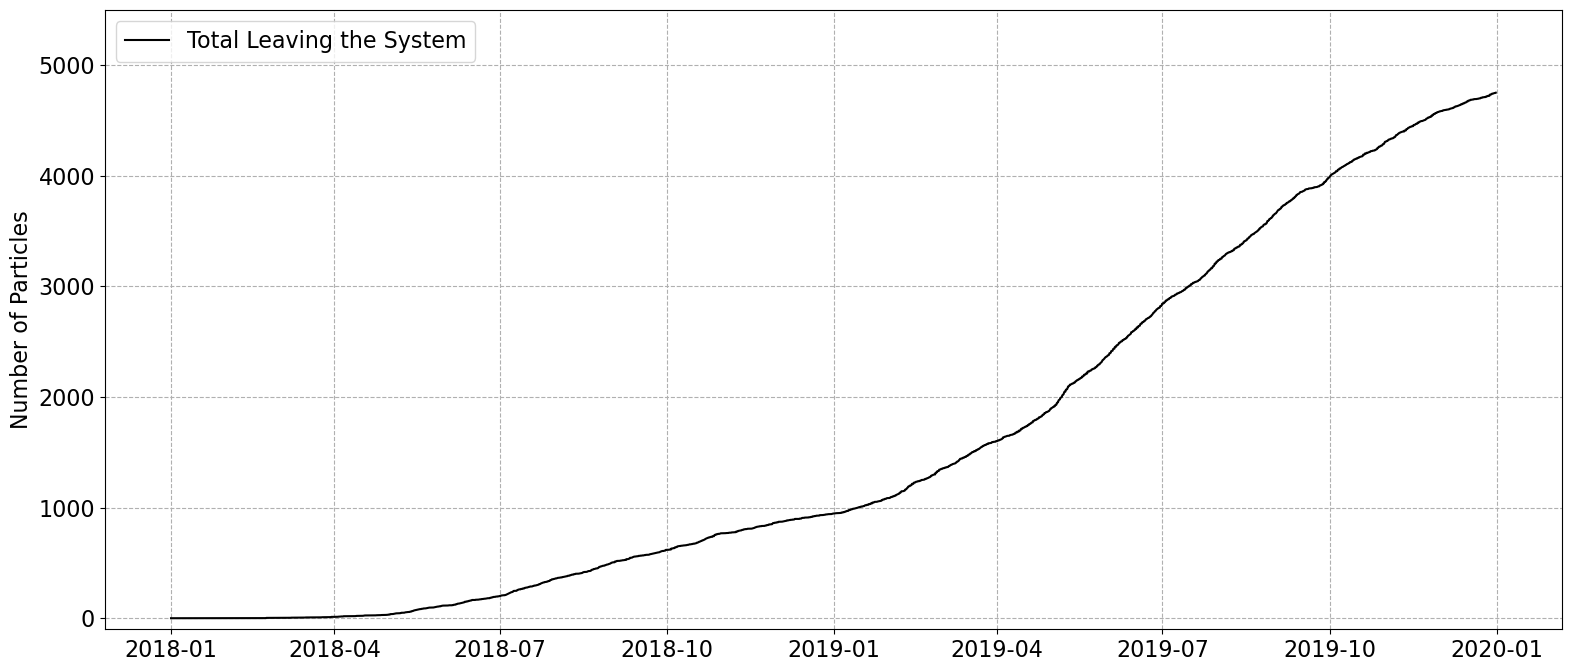

In [12]:
plt.rcParams.update({'font.size': 16})
#
fig, ax = plt.subplots(figsize = (16, 7))
ax.plot(data_combined.time[0], p_data_combined['out_jdf'] + p_data_combined['out_js'], 'k', label = 'Total Leaving the System')
ax.legend(loc = 'upper left')

#
ax.set_ylabel('Number of Particles')
#
ax.grid(linestyle = '--')
ax.set_ylim([-100, 5500])
#
plt.tight_layout()

:D

Proportion of seasons compared to total proportion

In [13]:
jjii = xr.open_dataset('/ocean/vvalenzuela/MOAD/grid/grid_from_lat_lon_mask999.nc')
def finder(lati,loni):
    j = [jjii.jj.sel(lats=lati, lons=loni, method='nearest').item()][0]
    i = [jjii.ii.sel(lats=lati, lons=loni, method='nearest').item()][0]
    return j,i

In [14]:
finder(50, -126)

(793, 9)

In [15]:
mask = xr.open_dataset('/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc')
bathy = xr.open_dataset('/ocean/vvalenzuela/MOAD/grid/bathymetry_202108.nc')
colors = [(0, 0, 0, 1),  # Black for land (1)
          (0, 0, 0, 0)]  # Transparent for water (0)
cmap = ListedColormap(colors)

In [16]:
lat_source = 49.195045
lon_source = -123.301956
y_source, x_source = finder(lat_source, lon_source)

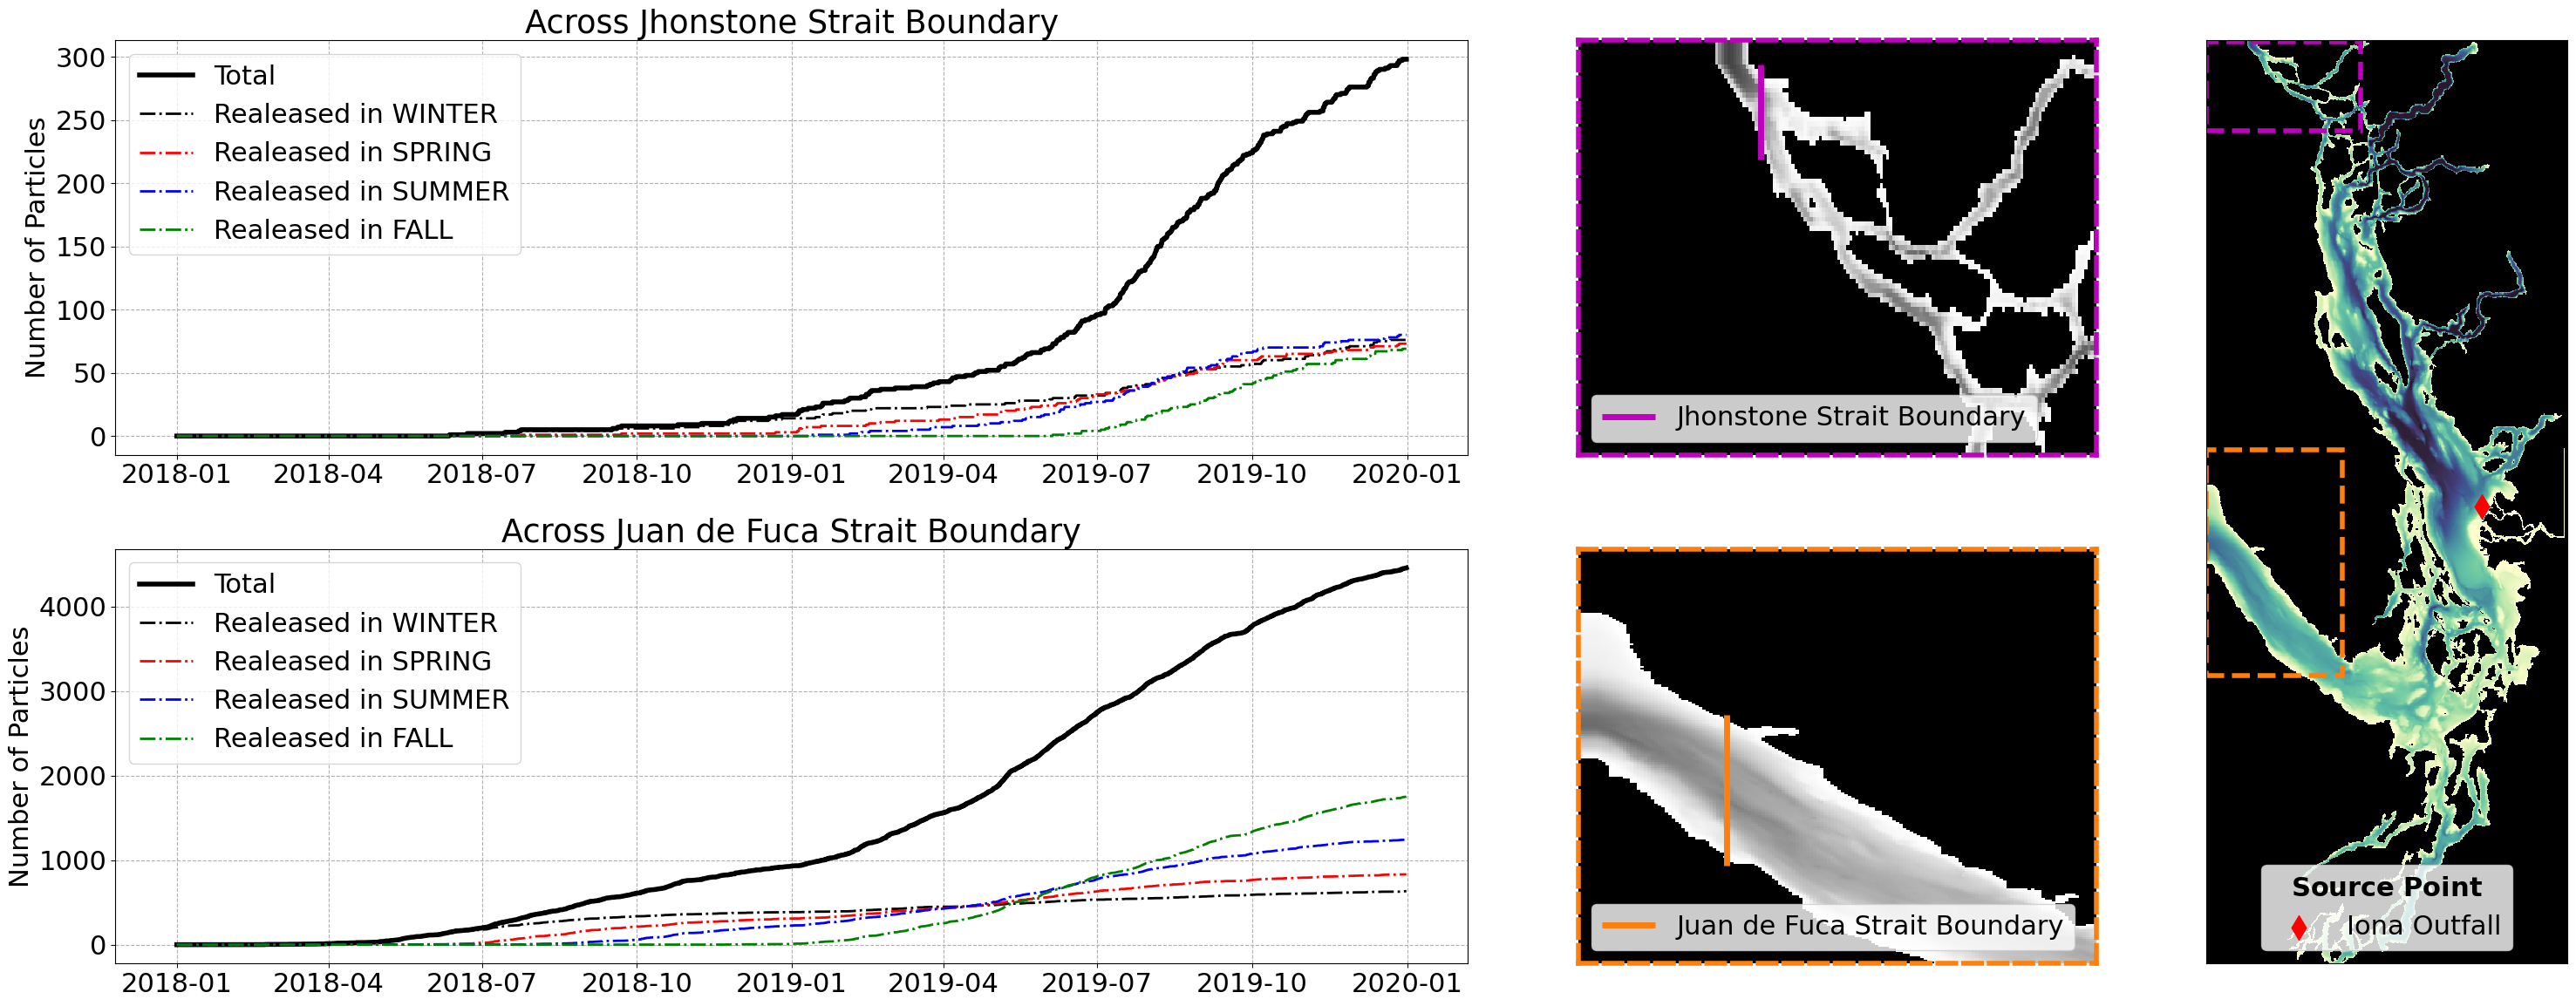

In [17]:
plt.rcParams.update({'font.size': 22})
#
fig = plt.figure(figsize=(30, 12))
gs = gridspec.GridSpec(2, 3, width_ratios=[3,1.15,.8])

ax2 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0])
axis_JdF = fig.add_subplot(gs[1, 1])
axis_Js = fig.add_subplot(gs[0, 1])
ax5 = fig.add_subplot(gs[0:2, 2])
#
ax1.plot(data_combined.time[0], p_data_combined['out_jdf'], 'k', linewidth = 4, label = 'Total')
ax1.plot(data_combined.time[0], p_particles_JFM['out_jdf'], '-.k', linewidth = 2, label = 'Realeased in WINTER')
ax1.plot(data_combined.time[0], p_particles_AMJ['out_jdf'], '-.r', linewidth = 2,  label = 'Realeased in SPRING')
ax1.plot(data_combined.time[0], p_particles_JAS['out_jdf'], '-.b', linewidth = 2,  label = 'Realeased in SUMMER')
ax1.plot(data_combined.time[0], p_particles_OND['out_jdf'], '-.g', linewidth = 2,  label = 'Realeased in FALL')
#
ax1.legend(); ax1.grid(linestyle = '--'); ax1.set_ylabel('Number of Particles'); ax1.set_title('Across Juan de Fuca Strait Boundary')
##
#
ax2.plot(data_combined.time[0], p_data_combined['out_js'], 'k', linewidth = 4, label = 'Total')
ax2.plot(data_combined.time[0], p_particles_JFM['out_js'], '-.k', linewidth = 2,  label = 'Realeased in WINTER')
ax2.plot(data_combined.time[0], p_particles_AMJ['out_js'], '-.r', linewidth = 2,  label = 'Realeased in SPRING')
ax2.plot(data_combined.time[0], p_particles_JAS['out_js'], '-.b', linewidth = 2,  label = 'Realeased in SUMMER')
ax2.plot(data_combined.time[0], p_particles_OND['out_js'], '-.g', linewidth = 2,  label = 'Realeased in FALL')
#
ax2.legend(); ax2.grid(linestyle = '--'); ax2.set_ylabel('Number of Particles'); ax2.set_title('Across Jhonstone Strait Boundary')
#
#
axis_JdF.pcolormesh(mask.tmask[0][0], cmap=cmap, shading='auto')
axis_JdF.pcolormesh(bathy.Bathymetry, cmap='Greys', shading='auto')
axis_JdF.set_xlim([0,150]); axis_JdF.set_ylim([280,500])
axis_JdF.vlines(x = 43, ymin=332, ymax = 412, linewidth = 5, colors='tab:orange', label = 'Juan de Fuca Strait Boundary')
axis_JdF.tick_params(which='both',bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
axis_JdF.legend(loc='lower left')

#
axis_Js.pcolormesh(mask.tmask[0][0], cmap=cmap, shading='auto')
axis_Js.pcolormesh(bathy.Bathymetry, cmap='Greys', shading='auto')
axis_Js.set_xlim([0,170]); axis_Js.set_ylim([810,897])
axis_Js.vlines(x = 60, ymin=872, ymax = 892, linewidth = 5, colors='m', label = 'Jhonstone Strait Boundary')
axis_Js.tick_params(which='both',bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
axis_Js.legend(loc='lower left')

#
#
ax5.pcolormesh(mask.tmask[0][0], cmap=cmap, shading='auto')
ax5.pcolormesh(bathy.Bathymetry, cmap=cm.deep, shading='auto')
ax5.tick_params(which='both',bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
#
import matplotlib.patches as patches

xlim_JdF = axis_JdF.get_xlim()
ylim_JdF = axis_JdF.get_ylim()

xlim_Js  = axis_Js.get_xlim()
ylim_Js  = axis_Js.get_ylim()

rect_JdF = patches.Rectangle((xlim_JdF[0], ylim_JdF[0]),
                             xlim_JdF[1]-xlim_JdF[0], ylim_JdF[1]-ylim_JdF[0],
                             linewidth=4, edgecolor='tab:orange', facecolor='none', linestyle = '--')
ax5.add_patch(rect_JdF)

rect_Js = patches.Rectangle((xlim_Js[0], ylim_Js[0]),
                            xlim_Js[1]-xlim_Js[0], ylim_Js[1]-ylim_Js[0],
                            linewidth=4, edgecolor='m', facecolor='none', linestyle = '--')
ax5.add_patch(rect_Js)
#
for spine in axis_JdF.spines.values():
    spine.set_edgecolor('tab:orange')
    spine.set_linewidth(4)
    spine.set_linestyle('--')

for spine in axis_Js.spines.values():
    spine.set_edgecolor('m')
    spine.set_linewidth(4)
    spine.set_linestyle('--') 
#
ax5.scatter(x_source, y_source, marker = 'd', color = 'r', s = 200, label = 'Iona Outfall')   
ax5.legend(loc = 'lower center', title = r"$\bf{Source \ Point}$")    
#
plt.tight_layout()

Compare each seasonal timeseries 

In [18]:
length = len(p_particles_JFM['out_jdf'].iloc[:(365+90)*4].values)

In [19]:
def first_crossing_index(arr, threshold):
    idx = np.where(arr > threshold)[0]
    return idx[0] if idx.size > 0 else None

In [30]:
# Compute medians
index_value_JdF = np.nanpercentile(p_data_combined['out_jdf'], q = 25)
index_value_Js  = np.nanpercentile(p_data_combined['out_js'], q = 25)

# JdF indices
index_JdF_JFM_0 = first_crossing_index(p_particles_JFM['out_jdf'].iloc[:(365+90)*4].values, index_value_JdF)
index_JdF_AMJ_0 = first_crossing_index(p_particles_AMJ['out_jdf'].iloc[90*4:(365+181)*4].values, index_value_JdF)
index_JdF_JAS_0 = first_crossing_index(p_particles_JAS['out_jdf'].iloc[181*4:(365+273)*4].values, index_value_JdF)
index_JdF_OND_0 = first_crossing_index(p_particles_OND['out_jdf'].iloc[273*4:].values, index_value_JdF)

# Js indices
index_Js_JFM_0 = first_crossing_index(p_particles_JFM['out_js'].iloc[:(365+90)*4].values, index_value_Js)
index_Js_AMJ_0 = first_crossing_index(p_particles_AMJ['out_js'].iloc[90*4:(365+181)*4].values, index_value_Js)
index_Js_JAS_0 = first_crossing_index(p_particles_JAS['out_js'].iloc[181*4:(365+273)*4].values, index_value_Js)
index_Js_OND_0 = first_crossing_index(p_particles_OND['out_js'].iloc[273*4:].values, index_value_Js)


In [31]:
def safe_days(idx, step=5):
    if idx is None or np.isnan(idx):
        return np.nan
    return idx / step
#
JdF_days = [
    safe_days(index_JdF_JFM_0),
    safe_days(index_JdF_AMJ_0),
    safe_days(index_JdF_JAS_0),
    safe_days(index_JdF_OND_0),
]
#
Js_days = [
    safe_days(index_Js_JFM_0),
    safe_days(index_Js_AMJ_0),
    safe_days(index_Js_JAS_0),
    safe_days(index_Js_OND_0),
]

seasons = ['WINTER', 'SPRING', 'SUMMER', 'FALL']


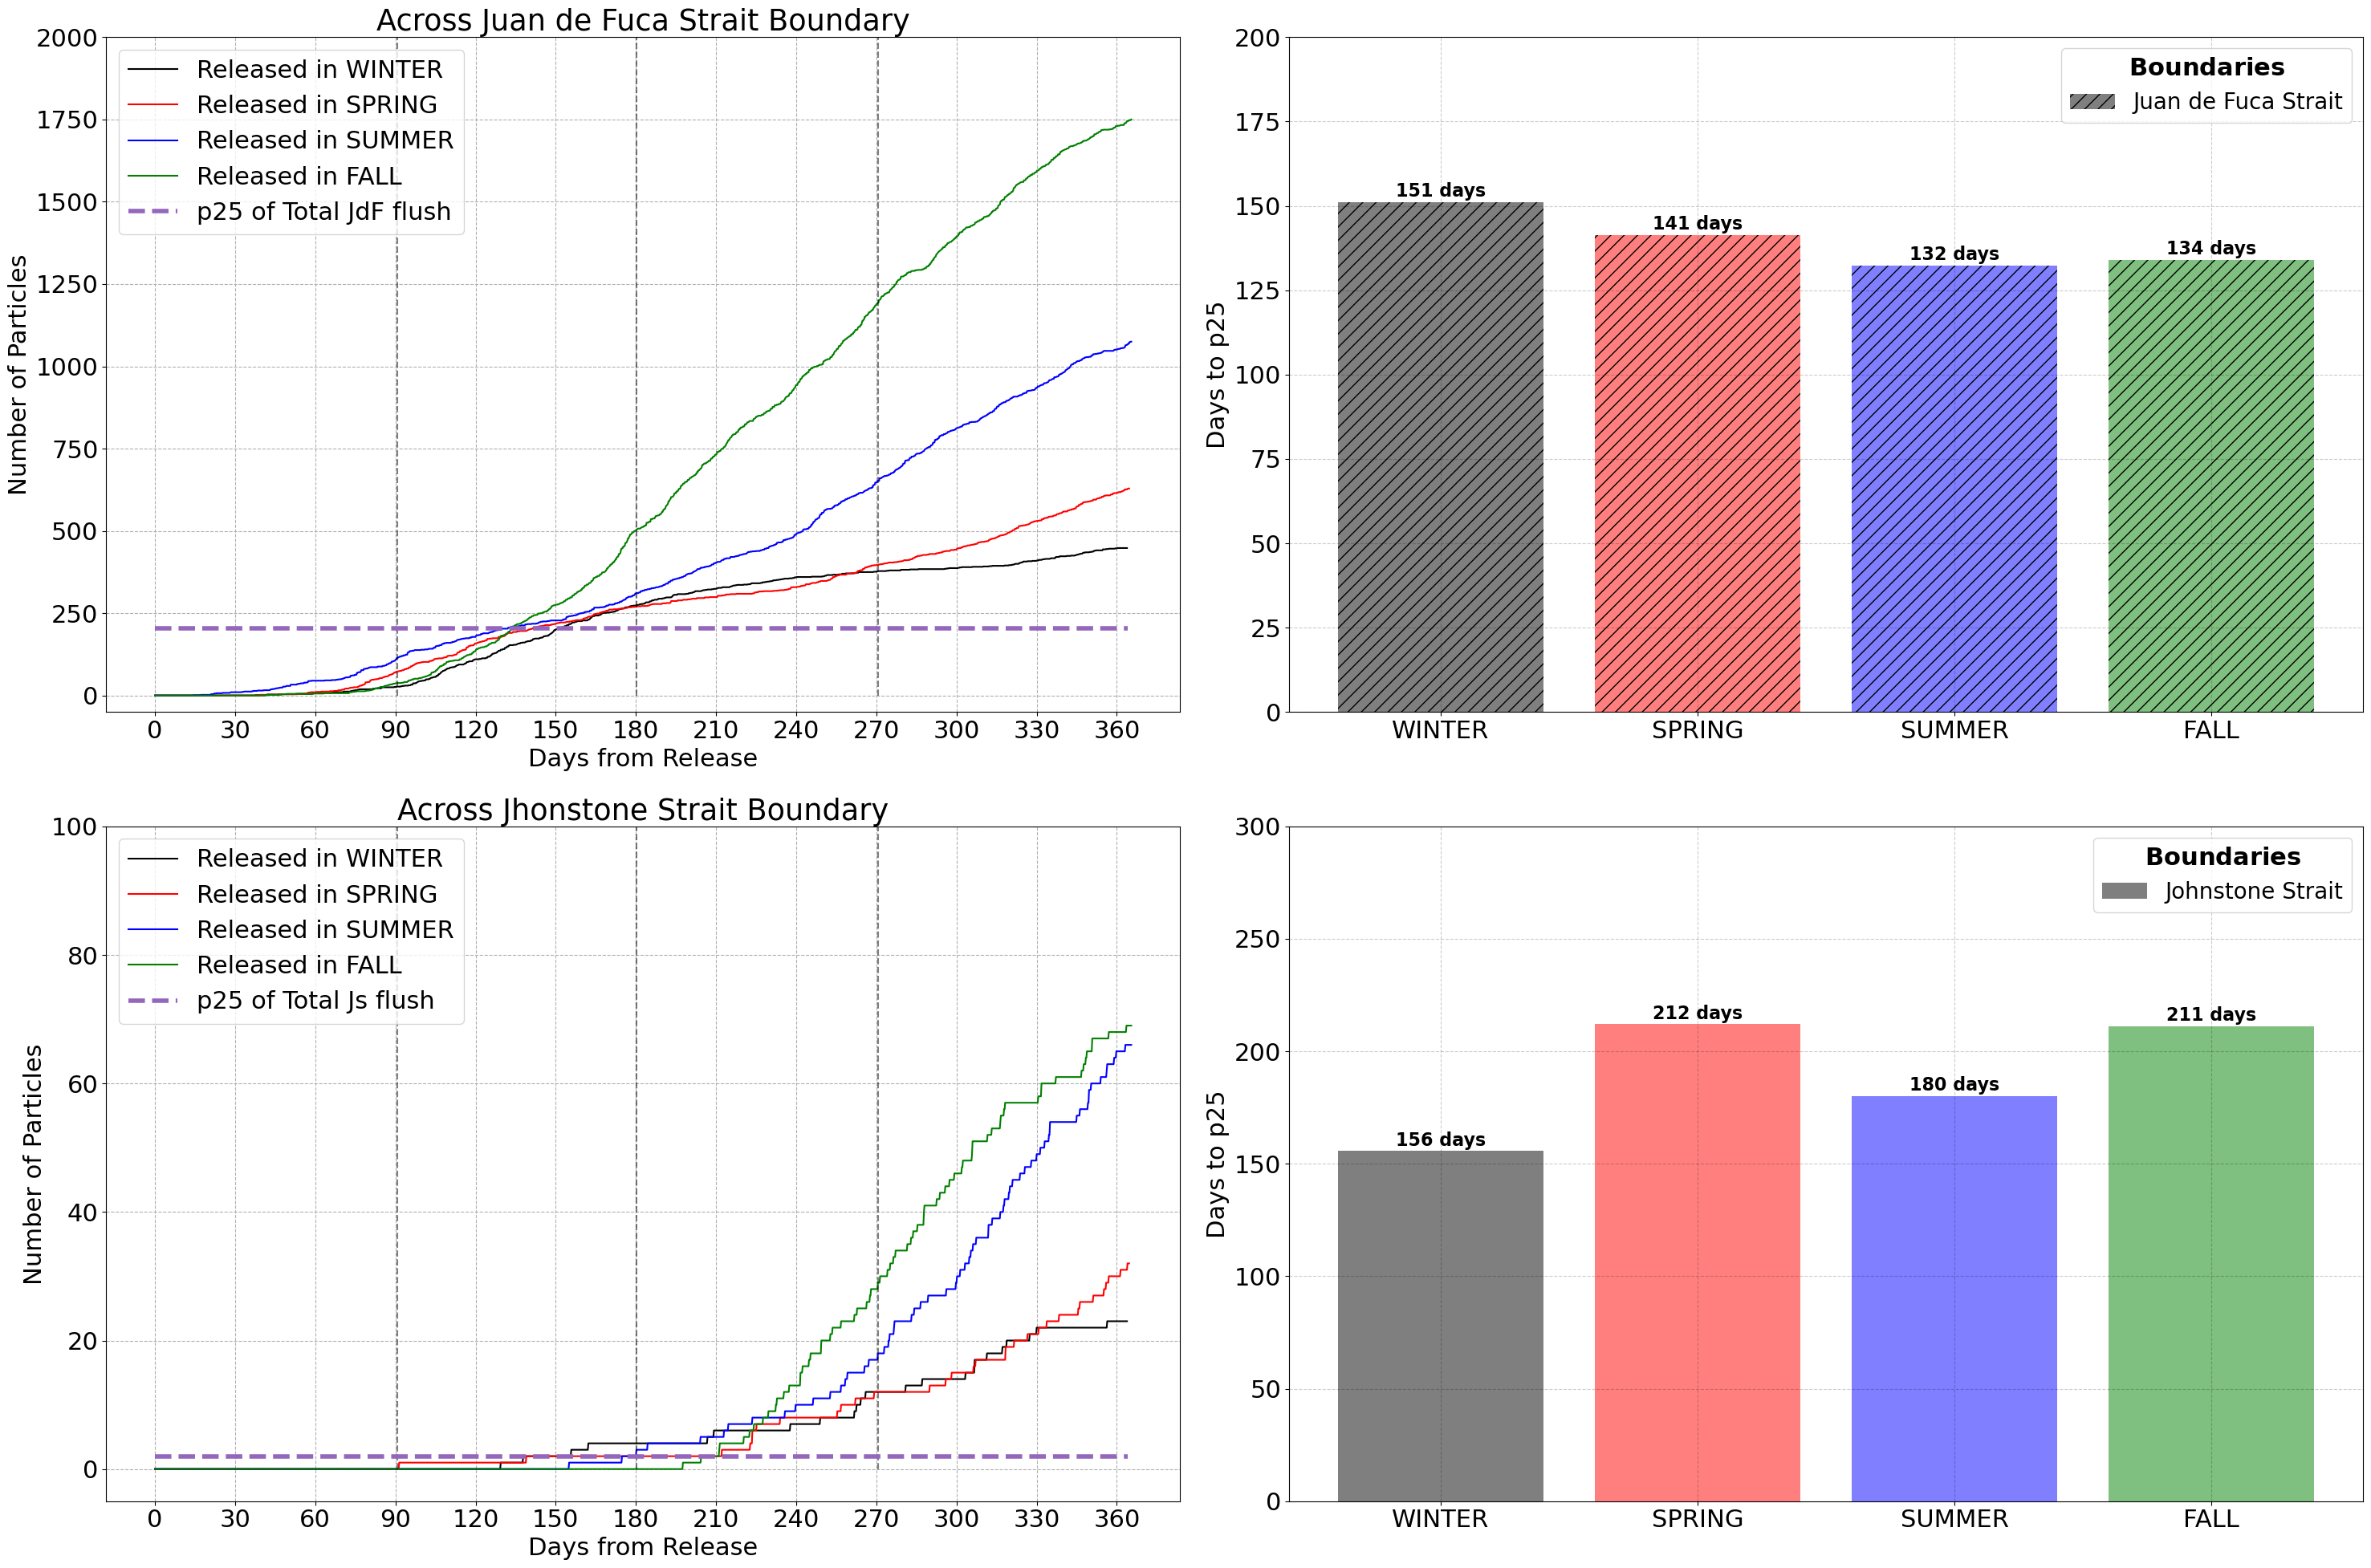

In [65]:
fig, ax = plt.subplots(2,2,figsize = (30,20))
ax[0,0].plot(p_particles_JFM['out_jdf'].iloc[:(365+90)*4].values, 'k', label = 'Released in WINTER')
ax[0,0].plot(p_particles_AMJ['out_jdf'].iloc[90*4:(365+181)*4].values, 'r', label = 'Released in SPRING')
ax[0,0].plot(p_particles_JAS['out_jdf'].iloc[181*4:(365+273)*4].values, 'b', label = 'Released in SUMMER')
ax[0,0].plot(p_particles_OND['out_jdf'].iloc[273*4:].values, 'g', label = 'Released in FALL')
ax[0,0].set_ylim([-50, 2000])
ax[0,0].set_title('Across Juan de Fuca Strait Boundary')
ax[0,0].vlines(x = length / 4 - 2 , ymin=0, ymax=2000, color = 'k', linestyle = '--', alpha = .5)
ax[0,0].vlines(x = length / 2 - 9, ymin=0, ymax=2000, color = 'k', linestyle = '--', alpha = .5)
ax[0,0].vlines(x = length / 4 + length / 2 - 12 , ymin=0, ymax=2000, color = 'k', linestyle = '--', alpha = .5)
ax[0,0].hlines(y = index_value_JdF, xmin=0, xmax = 1820, color = 'tab:purple', linestyle = '--', linewidth=4, label = r'p25 of Total JdF flush')

#
#
ax[1,0].plot(p_particles_JFM['out_js'].iloc[:(365+90)*4].values, 'k', label = 'Released in WINTER')
ax[1,0].plot(p_particles_AMJ['out_js'].iloc[90*4:(365+181)*4].values, 'r', label = 'Released in SPRING')
ax[1,0].plot(p_particles_JAS['out_js'].iloc[181*4:(365+273)*4].values, 'b', label = 'Released in SUMMER')
ax[1,0].plot(p_particles_OND['out_js'].iloc[273*4:].values, 'g', label = 'Released in FALL')
ax[1,0].set_ylim([-5, 100])
ax[1,0].set_title('Across Jhonstone Strait Boundary')
ax[1,0].vlines(x = length / 4 - 2 , ymin=0, ymax=2000, color = 'k', linestyle = '--', alpha = .5)
ax[1,0].vlines(x = length / 2 - 9, ymin=0, ymax=2000, color = 'k', linestyle = '--', alpha = .5)
ax[1,0].vlines(x = length / 4 + length / 2 - 12 , ymin=0, ymax=2000, color = 'k', linestyle = '--', alpha = .5)
ax[1,0].hlines(y = index_value_Js, xmin=0, xmax = 1820, color = 'tab:purple', linestyle = '--', linewidth=4, label = r'p25 of Total Js flush')

#
#
days = np.arange(0, 366, 30)       # ticks every 30 days
tick_positions = days * 5          # since 4 data points per day
for a in ax[:,0]:
    a.set_xticks(tick_positions)
    a.set_xticklabels(days)
    a.set_xlabel('Days from Release')
    a.grid(linestyle = '--')
    a.legend(loc = 'upper left')
    a.set_ylabel('Number of Particles')
#
# 
bar_JdF = ax[0,1].bar(
    seasons,
    [0 if np.isnan(v) else v for v in JdF_days],
    color=['k', 'r', 'b', 'g'],
    alpha=.5,
    hatch='//',
    label='Juan de Fuca Strait'
)

for bar, value in zip(bar_JdF, JdF_days):
    if not np.isnan(value):
        ax[0,1].text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.5,
            f'{int(np.round(value))} days',
            ha='center', va='bottom',
            fontsize=16, fontweight='bold'
        )

# --- Js bars ---
bar_Js = ax[1,1].bar(
    seasons,
    [0 if np.isnan(v) else v for v in Js_days],
    color=['k', 'r', 'b', 'g'],
    alpha=.5,
    label='Johnstone Strait'
)

for bar, value in zip(bar_Js, Js_days):
    if not np.isnan(value):
        ax[1,1].text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.5,
            f'{int(np.round(value))} days',
            ha='center', va='bottom',
            fontsize=16, fontweight='bold'
        )

# --- Formatting ---
ax[0,1].grid(linestyle='--', color='k', alpha=.2)
ax[0,1].set_ylim([0, 200])
ax[0,1].set_ylabel('Days to p25')
ax[0,1].legend(title=r"$\bf{Boundaries}$", fontsize=20, loc='upper right')
#
ax[1,1].grid(linestyle='--', color='k', alpha=.2)
ax[1,1].set_ylim([0, 300])
ax[1,1].set_ylabel('Days to p25')
ax[1,1].legend(title=r"$\bf{Boundaries}$", fontsize=20, loc='upper right')
#
plt.tight_layout()

# What about the regions?

Similar as other analysis, but just keep 4 regions for faster coding and running :)

In [24]:
from Regions_functions_V2 import polygon_coors_N2, polygon_coors_N3, polygon_coors_H1, polygon_coors_J1, points_inside

In [25]:
def polygon_definition_data(data, time_step='month'):
    #
    time_values = pd.to_datetime(data.time[0, :])
    
    df_time = pd.DataFrame({'time': time_values})
    
    if time_step == 'month':
        df_time['period'] = df_time['time'].dt.to_period('M')
    elif time_step == 'week':
        df_time['period'] = df_time['time'].dt.to_period('W')
    elif time_step == 'day':
        df_time['period'] = df_time['time'].dt.to_period('D')
    else:
        raise ValueError("time_step must be 'day', 'week', or 'month'")
    
    last_of_period_indices = df_time.groupby('period').tail(1).index

    outputs = ['depth', 'lon', 'lat', 'status', 'n_particles', 'month']
    n_steps = len(last_of_period_indices)

    polygons_dict = {
        'N2': (polygon_coors_N2, pd.DataFrame(columns=outputs, index=np.arange(n_steps), dtype=object)),
        'N3': (polygon_coors_N3, pd.DataFrame(columns=outputs, index=np.arange(n_steps), dtype=object)),
        'H1': (polygon_coors_H1, pd.DataFrame(columns=outputs, index=np.arange(n_steps), dtype=object)),
        'J1': (polygon_coors_J1, pd.DataFrame(columns=outputs, index=np.arange(n_steps), dtype=object))
    }

    for step_index, i in enumerate(last_of_period_indices):
        current_month = time_values[i].month  # numeric month (1–12)
    
        for key, (polygon, data_sets) in polygons_dict.items():
            depth_region, lon_region, lat_region, status_region, n_part = points_inside(polygon, data, t=i)
    
            months_region = [current_month] * len(depth_region)  # one month per particle
            data_sets.iloc[step_index] = [
                depth_region, lon_region, lat_region, status_region, n_part, months_region
            ]

    return polygons_dict

In [26]:
polygon_winter = polygon_definition_data(data=particles_JAN_FEB_MAR, time_step='day')
polygon_spring = polygon_definition_data(data=particles_APR_MAY_JUN, time_step='day')
polygon_summer = polygon_definition_data(data=particles_JUL_AUG_SEP, time_step='day')
polygon_fall = polygon_definition_data(data=particles_OCT_NOV_DEC, time_step='day')

In [27]:
def water_sediment_count(polygon, data, t):
    #
    _, _, _, status_inside, _ = points_inside(polygon, data, t)
    #
    water_status = [1, 2, 3]
    sediment_status = [11, 12, 13]
    #
    water_count = np.isin(status_inside, water_status).sum()
    sediment_count = np.isin(status_inside, sediment_status).sum()
    #
    return water_count, sediment_count

In [28]:
season_datasets = {
    'winter': particles_JAN_FEB_MAR,
    'spring': particles_APR_MAY_JUN,
    'summer': particles_JUL_AUG_SEP,
    'fall': particles_OCT_NOV_DEC
}

season_polygons = {
    'winter': polygon_winter,
    'spring': polygon_spring,
    'summer': polygon_summer,
    'fall': polygon_fall
}

region_names = ['N2', 'N3', 'H1', 'J1']
step = 1

season_results = {
    'winter': {'water': {}, 'sediment': {}},
    'spring': {'water': {}, 'sediment': {}},
    'summer': {'water': {}, 'sediment': {}},
    'fall': {'water': {}, 'sediment': {}}
}

for season in season_datasets.keys():
    data = season_datasets[season]
    polygons = season_polygons[season]
    time_indices = np.arange(0, len(data.obs), step)

    for region in region_names:
        water_arr = np.zeros(len(time_indices))
        sediment_arr = np.zeros(len(time_indices))
        polygon = polygons[region][0]

        for idx, t in enumerate(time_indices):
            water_arr[idx], sediment_arr[idx] = water_sediment_count(polygon, data, t)

        season_results[season]['water'][region] = water_arr
        season_results[season]['sediment'][region] = sediment_arr

Me trying to balance run time and matching the changes heheh c:

In [34]:
particles_JAN_FEB_MAR.time[0,:(365+90)*4].values

array(['2022-01-01T00:30:00.000000000', '2022-01-01T06:30:00.000000000',
       '2022-01-01T12:30:00.000000000', ...,
       '2023-03-31T00:30:00.000000000', '2023-03-31T06:30:00.000000000',
       '2023-03-31T12:30:00.000000000'], dtype='datetime64[ns]')

In [36]:
particles_APR_MAY_JUN.time[0,90*4:(365+181)*4].values

array(['2022-04-01T00:30:00.000000000', '2022-04-01T06:30:00.000000000',
       '2022-04-01T12:30:00.000000000', ...,
       '2023-06-30T00:30:00.000000000', '2023-06-30T06:30:00.000000000',
       '2023-06-30T12:30:00.000000000'], dtype='datetime64[ns]')

In [38]:
particles_JUL_AUG_SEP.time[0,181*4:(365+273)*4].values

array(['2022-07-01T00:30:00.000000000', '2022-07-01T06:30:00.000000000',
       '2022-07-01T12:30:00.000000000', ...,
       '2023-09-30T00:30:00.000000000', '2023-09-30T06:30:00.000000000',
       '2023-09-30T12:30:00.000000000'], dtype='datetime64[ns]')

In [40]:
particles_OCT_NOV_DEC.time[0,273*4:].values

array(['2022-10-01T00:30:00.000000000', '2022-10-01T06:30:00.000000000',
       '2022-10-01T12:30:00.000000000', ...,
       '2023-12-16T18:30:00.000000000', '2023-12-17T00:30:00.000000000',
       '2023-12-17T06:30:00.000000000'], dtype='datetime64[ns]')

In [41]:
tt = particles_JAN_FEB_MAR.time[0,time_indices].values

Change this to the new index values for percentage instead of the first point to reach the region...

In [53]:
p25_N2 = np.nanpercentile(season_results['winter']['water']['N2'] + season_results['spring']['water']['N2'] + season_results['summer']['water']['N2'] + season_results['fall']['water']['N2'], q = 25)
p25_N3 = np.nanpercentile(season_results['winter']['water']['N3'] + season_results['spring']['water']['N3'] + season_results['summer']['water']['N3'] + season_results['fall']['water']['N3'], q = 25)
p25_H1 = np.nanpercentile(season_results['winter']['water']['H1'] + season_results['spring']['water']['H1'] + season_results['summer']['water']['H1'] + season_results['fall']['water']['H1'], q = 25)
p25_J1 = np.nanpercentile(season_results['winter']['water']['J1'] + season_results['spring']['water']['J1'] + season_results['summer']['water']['J1'] + season_results['fall']['water']['J1'], q = 25)

In [54]:
# N2 indices
index_N2_JFM_0 = first_crossing_index(season_results['winter']['water']['N2'][:(365+90)*4], p25_N2)
index_N2_AMJ_0 = first_crossing_index(season_results['spring']['water']['N2'][90*4:(365+181)*4], p25_N2)
index_N2_JAS_0 = first_crossing_index(season_results['summer']['water']['N2'][181*4:(365+273)*4], p25_N2)
index_N2_OND_0 = first_crossing_index(season_results['fall']['water']['N2'][273*4:], p25_N2)
# N3 indices
index_N3_JFM_0 = first_crossing_index(season_results['winter']['water']['N3'][:(365+90)*4], p25_N3)
index_N3_AMJ_0 = first_crossing_index(season_results['spring']['water']['N3'][90*4:(365+181)*4], p25_N3)
index_N3_JAS_0 = first_crossing_index(season_results['summer']['water']['N3'][181*4:(365+273)*4], p25_N3)
index_N3_OND_0 = first_crossing_index(season_results['fall']['water']['N3'][273*4:], p25_N3)
# H1 indices
index_H1_JFM_0 = first_crossing_index(season_results['winter']['water']['H1'][:(365+90)*4], p25_H1)
index_H1_AMJ_0 = first_crossing_index(season_results['spring']['water']['H1'][90*4:(365+181)*4], p25_H1)
index_H1_JAS_0 = first_crossing_index(season_results['summer']['water']['H1'][181*4:(365+273)*4], p25_H1)
index_H1_OND_0 = first_crossing_index(season_results['fall']['water']['H1'][273*4:], p25_H1)
# J1 indices
index_J1_JFM_0 = first_crossing_index(season_results['winter']['water']['J1'][:(365+90)*4], p25_J1)
index_J1_AMJ_0 = first_crossing_index(season_results['spring']['water']['J1'][90*4:(365+181)*4], p25_J1)
index_J1_JAS_0 = first_crossing_index(season_results['summer']['water']['J1'][181*4:(365+273)*4], p25_J1)
index_J1_OND_0 = first_crossing_index(season_results['fall']['water']['J1'][273*4:], p25_J1)

In [55]:
N2_days = [
    safe_days(index_N2_JFM_0),
    safe_days(index_N2_AMJ_0),
    safe_days(index_N2_JAS_0),
    safe_days(index_N2_OND_0),
]
#
N3_days = [
    safe_days(index_N3_JFM_0),
    safe_days(index_N3_AMJ_0),
    safe_days(index_N3_JAS_0),
    safe_days(index_N3_OND_0),
]
#
H1_days = [
    safe_days(index_H1_JFM_0),
    safe_days(index_H1_AMJ_0),
    safe_days(index_H1_JAS_0),
    safe_days(index_H1_OND_0),
]
#
J1_days = [
    safe_days(index_J1_JFM_0),
    safe_days(index_J1_AMJ_0),
    safe_days(index_J1_JAS_0),
    safe_days(index_J1_OND_0),
]

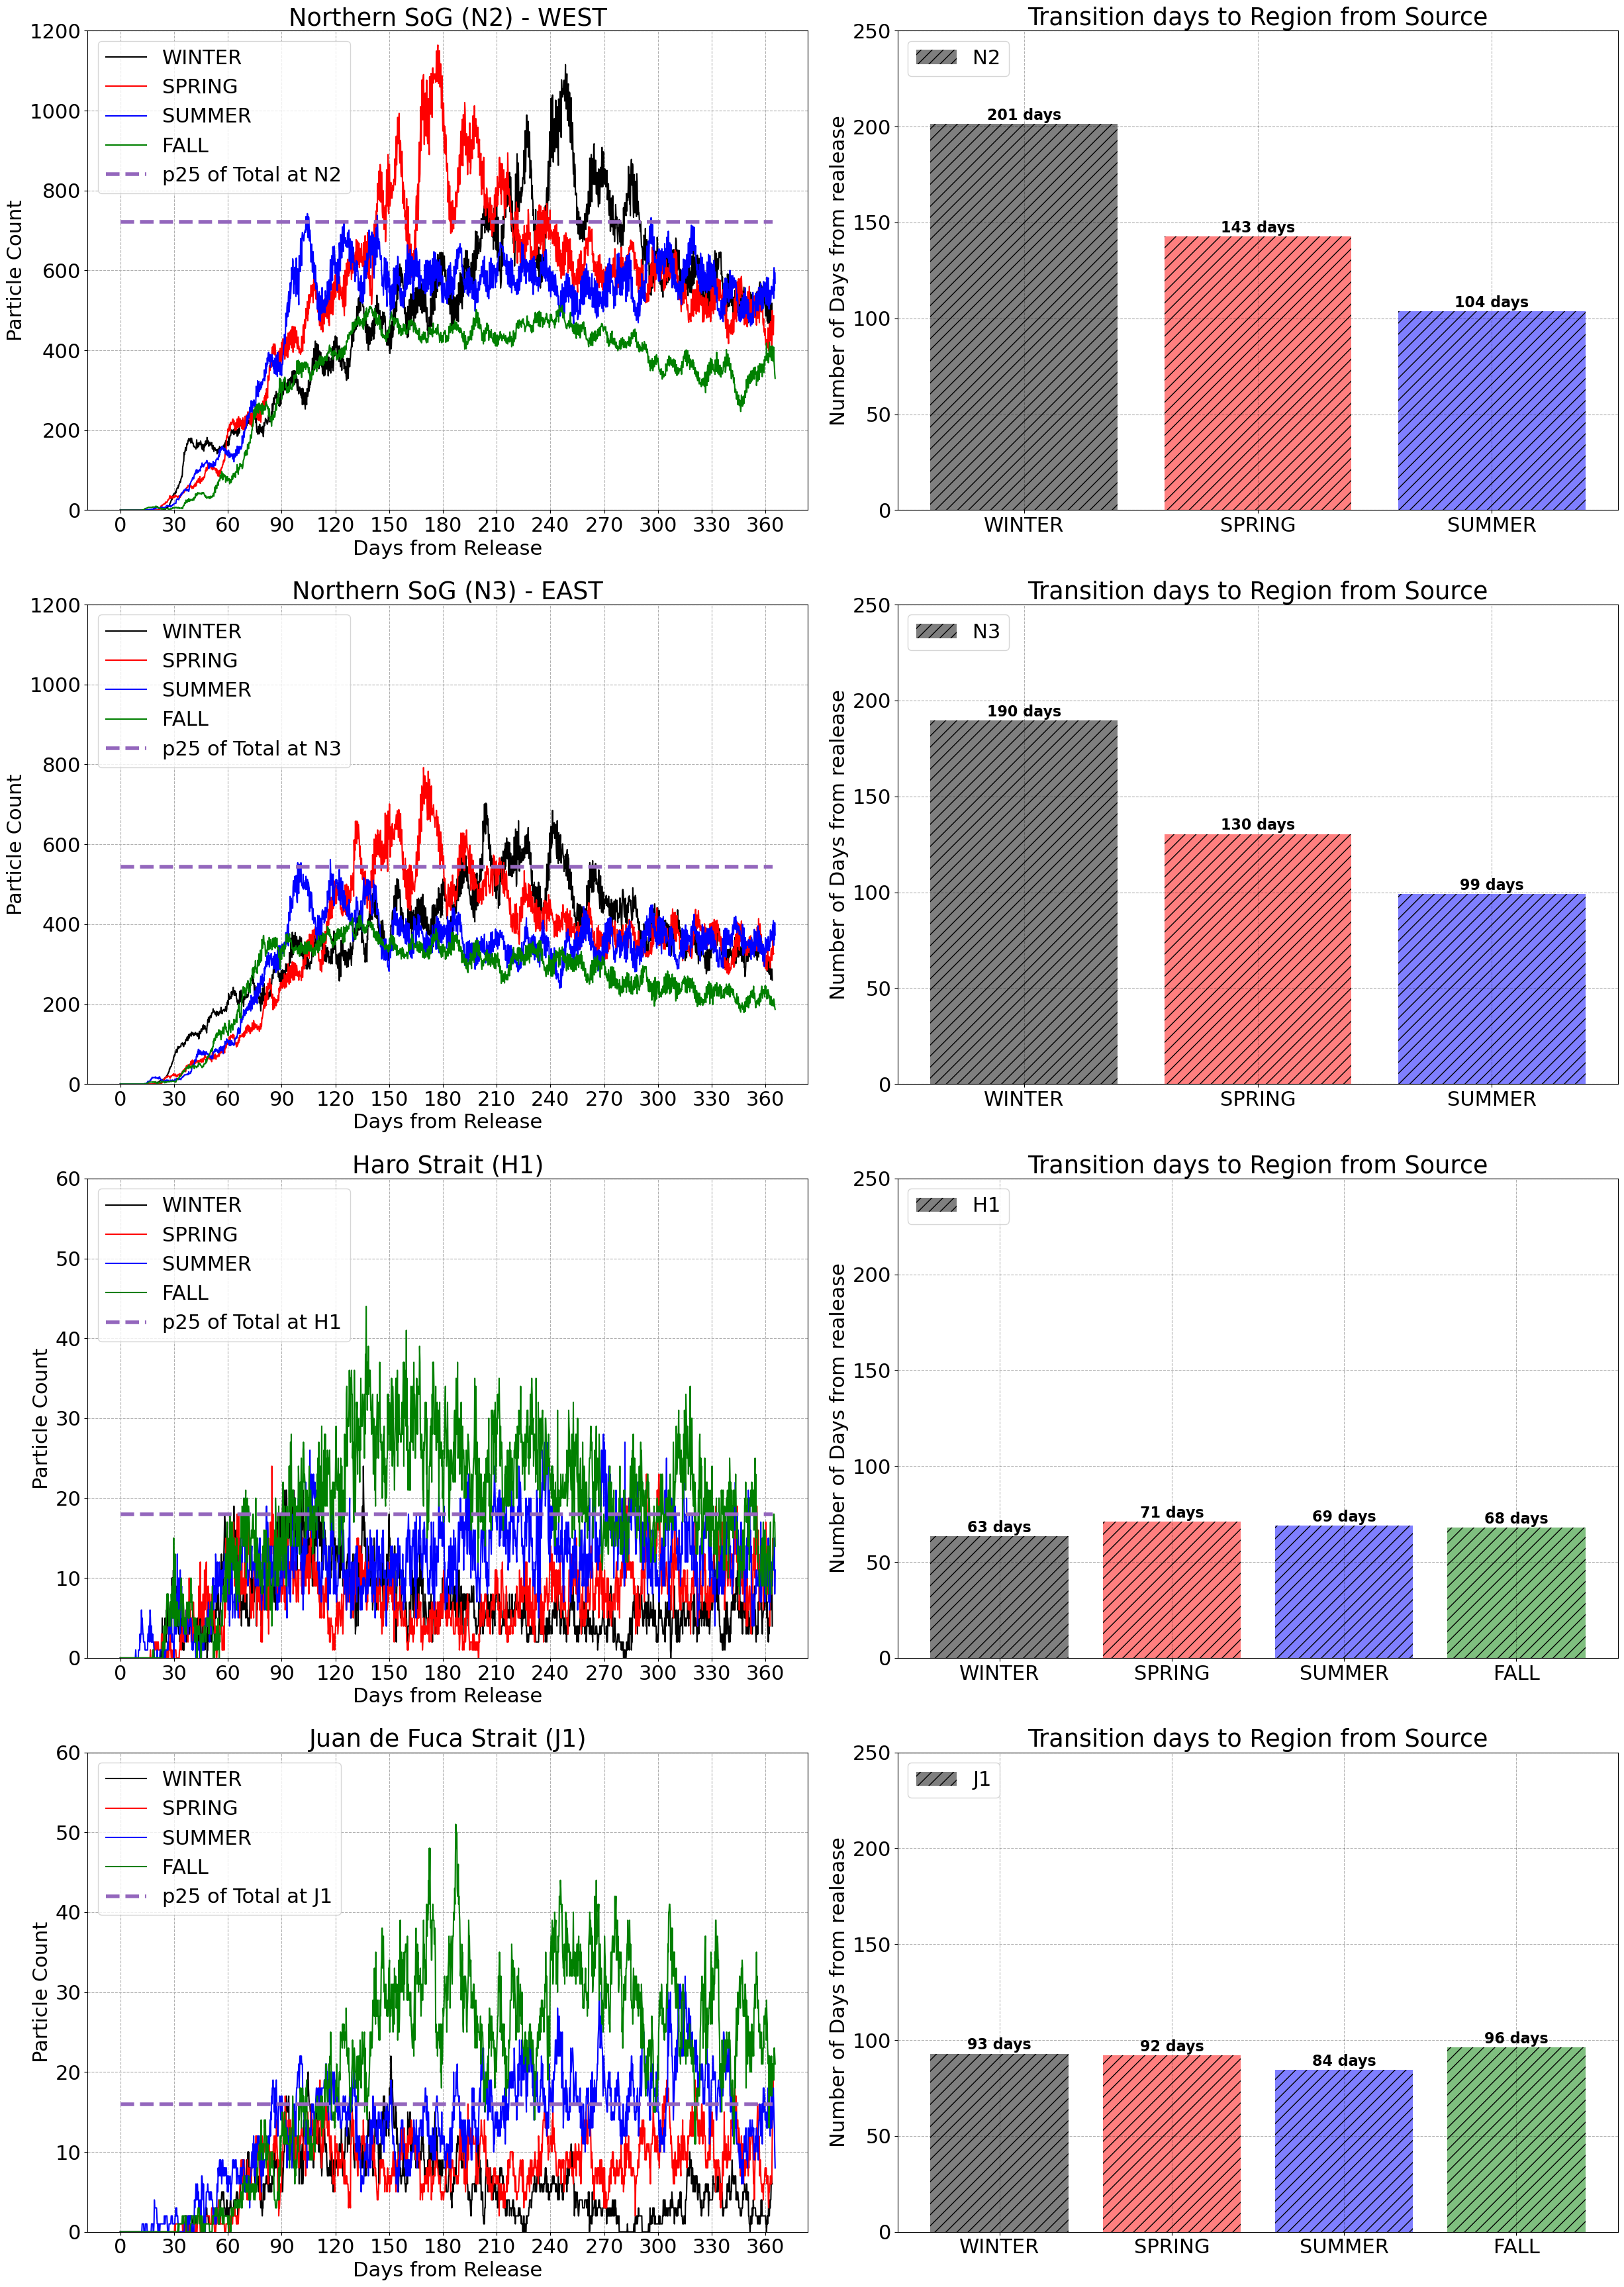

In [61]:
fig, ax = plt.subplots(4,2,figsize = (25,35))
ax[0,0].plot(season_results['winter']['water']['N2'][:(365+90)*4], 'k', label = 'WINTER')
ax[0,0].plot(season_results['spring']['water']['N2'][90*4:(365+181)*4], 'r', label = 'SPRING')
ax[0,0].plot(season_results['summer']['water']['N2'][181*4:(365+273)*4], 'b', label = 'SUMMER')
ax[0,0].plot(season_results['fall']['water']['N2'][273*4:], 'g', label = 'FALL')
ax[0,0].legend(); ax[0,0].set_title('Northern SoG (N2) - WEST'); ax[0,0].set_ylim([0, 1200])
ax[0,0].hlines(y = p25_N2, xmin=0, xmax = 1820, color = 'tab:purple', linestyle = '--', linewidth=4, label = r'p25 of Total at N2')

#
bar_N2 = ax[0,1].bar(seasons, N2_days, color = ['k', 'r', 'b', 'g'], alpha = .5, hatch = '//', label = 'N2') ; ax[0,1].set_ylim([0,250])
for bar, value in zip(bar_N2, N2_days):
    if not np.isnan(value):
        ax[0,1].text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.5, 
            f'{int(np.round(value))} days',
            ha='center', va='bottom', fontsize=16, fontweight='bold'
        )
#######
ax[1,0].plot(season_results['winter']['water']['N3'][:(365+90)*4], 'k', label = 'WINTER')
ax[1,0].plot(season_results['spring']['water']['N3'][90*4:(365+181)*4], 'r', label = 'SPRING')
ax[1,0].plot(season_results['summer']['water']['N3'][181*4:(365+273)*4], 'b', label = 'SUMMER')
ax[1,0].plot(season_results['fall']['water']['N3'][273*4:], 'g', label = 'FALL')
ax[1,0].legend(); ax[1,0].set_title('Northern SoG (N3) - EAST'); ax[1,0].set_ylim([0, 1200])
ax[1,0].hlines(y = p25_N3, xmin=0, xmax = 1820, color = 'tab:purple', linestyle = '--', linewidth=4, label = r'p25 of Total at N3')

#
bar_N3 = ax[1,1].bar(seasons, N3_days, color = ['k', 'r', 'b', 'g'], alpha = .5, hatch = '//', label = 'N3') ; ax[1,1].set_ylim([0,250])
for bar, value in zip(bar_N3, N3_days):
    if not np.isnan(value):
        ax[1,1].text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.5, 
            f'{int(np.round(value))} days',
            ha='center', va='bottom', fontsize=16, fontweight='bold'
        )
#######
ax[2,0].plot(season_results['winter']['water']['H1'][:(365+90)*4], 'k', label = 'WINTER')
ax[2,0].plot(season_results['spring']['water']['H1'][90*4:(365+181)*4], 'r', label = 'SPRING')
ax[2,0].plot(season_results['summer']['water']['H1'][181*4:(365+273)*4], 'b', label = 'SUMMER')
ax[2,0].plot(season_results['fall']['water']['H1'][273*4:], 'g', label = 'FALL')
ax[2,0].legend(); ax[2,0].set_title('Haro Strait (H1)'); ax[2,0].set_ylim([0, 60])
ax[2,0].hlines(y = p25_H1, xmin=0, xmax = 1820, color = 'tab:purple', linestyle = '--', linewidth=4, label = r'p25 of Total at H1')

#
bar_H1 = ax[2,1].bar(seasons, H1_days, color = ['k', 'r', 'b', 'g'], alpha = .5, hatch = '//', label = 'H1') ; ax[2,1].set_ylim([0,250])
for bar, value in zip(bar_H1, H1_days):
    if not np.isnan(value):
        ax[2,1].text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.5, 
            f'{int(np.round(value))} days',
            ha='center', va='bottom', fontsize=16, fontweight='bold'
        )
#######    
ax[3,0].plot(season_results['winter']['water']['J1'][:(365+90)*4], 'k', label = 'WINTER')
ax[3,0].plot(season_results['spring']['water']['J1'][90*4:(365+181)*4], 'r', label = 'SPRING')
ax[3,0].plot(season_results['summer']['water']['J1'][181*4:(365+273)*4], 'b', label = 'SUMMER')
ax[3,0].plot(season_results['fall']['water']['J1'][273*4:], 'g', label = 'FALL')
ax[3,0].legend(); ax[3,0].set_title('Juan de Fuca Strait (J1)'); ax[3,0].set_ylim([0, 60])
ax[3,0].hlines(y = p25_J1, xmin=0, xmax = 1820, color = 'tab:purple', linestyle = '--', linewidth=4, label = r'p25 of Total at J1')

#
bar_J1 = ax[3,1].bar(seasons, J1_days, color = ['k', 'r', 'b', 'g'], alpha = .5, hatch = '//', label = 'J1') ; ax[3,1].set_ylim([0,250])
for bar, value in zip(bar_J1, J1_days):
    if not np.isnan(value):
        ax[3,1].text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.5, 
            f'{int(np.round(value))} days',
            ha='center', va='bottom', fontsize=16, fontweight='bold'
        )
#################################################################    
days_regions = np.arange(0, 366, 30)
tick_positions_regions = days_regions * 5 
for a in ax[:,0]:
    a.set_xticks(tick_positions_regions)
    a.set_xticklabels(days_regions)
    a.set_xlabel('Days from Release')
    a.grid(linestyle = '--')
    a.legend(loc = 'upper left')
    a.set_ylabel('Particle Count')
#
for a in ax[:,1]:
    a.set_title('Transition days to Region from Source')
    a.grid(linestyle = '--', color='k', alpha = .3)
    a.legend(loc = 'upper left')
    a.set_ylabel('Number of Days from realease')    
plt.tight_layout()

Lets compare each region more visualy :D

In [66]:
from shapely.geometry import Polygon, Point
from Regions_functions_V2 import polygon_N2, polygon_N3, polygon_H1, polygon_J1 
def inside_polygon_xy(polygon, depth):
    mask = xr.open_dataset('/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc')
    
    tmask = mask['tmask'][0, depth].values
    x_coords, y_coords = np.meshgrid(np.arange(tmask.shape[1]), np.arange(tmask.shape[0]))
    
    # Flatten arrays
    x_flat = x_coords.ravel()
    y_flat = y_coords.ravel()
    tmask_flat = tmask.ravel()
    
    # Create shapely Points and check inside polygon
    points = np.array([Point(x, y) for x, y in zip(x_flat, y_flat)])
    inside_mask = np.array([polygon.contains(point) for point in points]) & (tmask_flat == 1)
    
    # Select x and y inside polygon
    x_inside = x_flat[inside_mask]
    y_inside = y_flat[inside_mask]
    
    return x_inside.tolist(), y_inside.tolist()
#
points_x_N2,points_y_N2 = inside_polygon_xy(polygon_N2, depth=0)
points_x_N3,points_y_N3 = inside_polygon_xy(polygon_N3, depth=0)
points_x_H1,points_y_H1 = inside_polygon_xy(polygon_H1, depth=0)
points_x_J1,points_y_J1 = inside_polygon_xy(polygon_J1, depth=0)


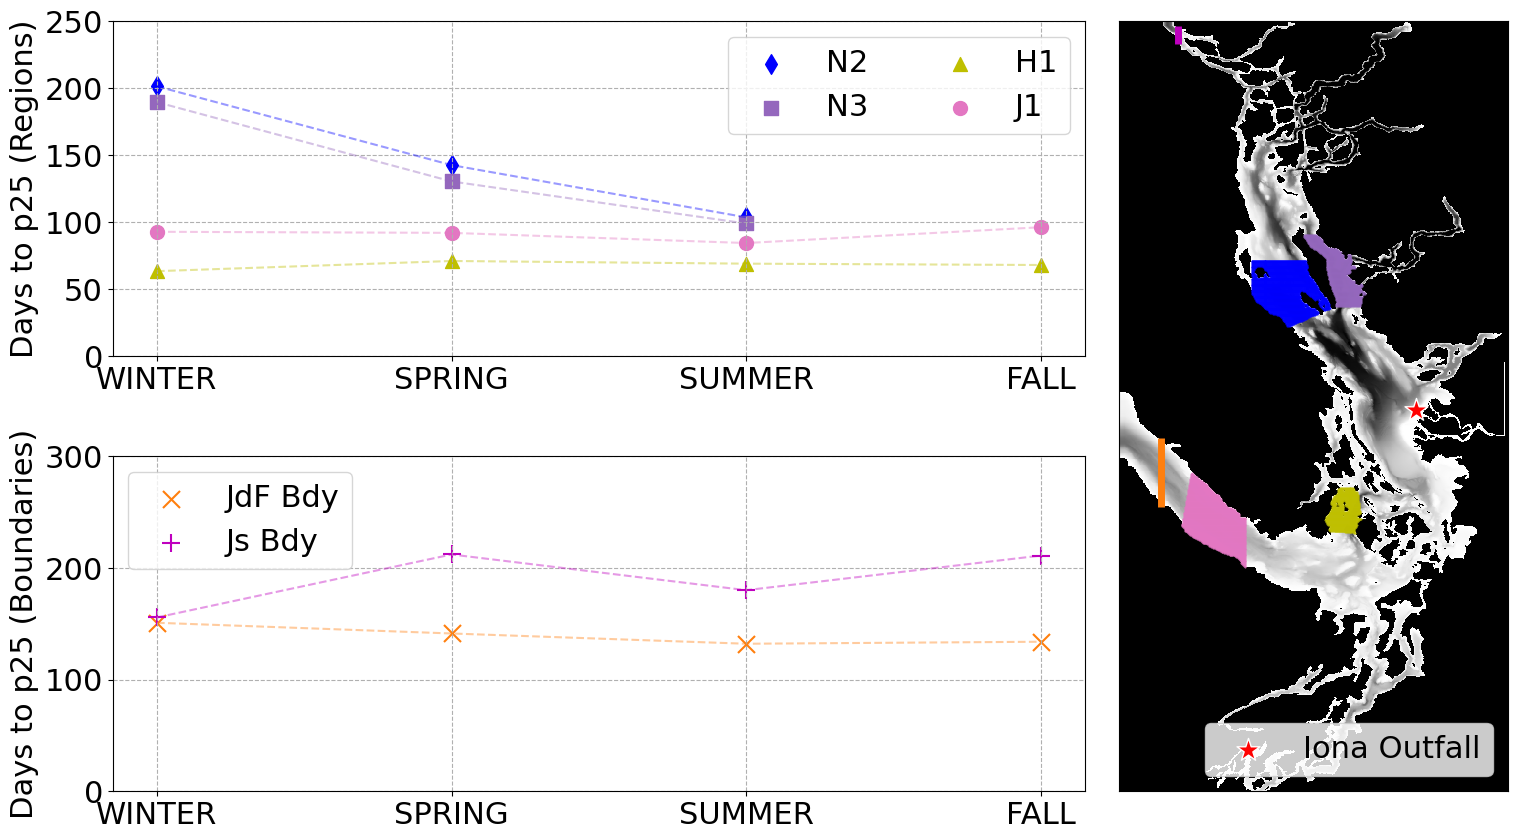

<Figure size 640x480 with 0 Axes>

In [70]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(18, 10))

# Adjust width ratio for closeness and set small wspace
gs = gridspec.GridSpec(2, 2, width_ratios=[2.5, 1], height_ratios=[1, 1], wspace=0.05, hspace=0.3)

# Left column (two rows sharing x-axis)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)

# Right column (map occupying both rows)
ax3 = fig.add_subplot(gs[:, 1])

ax1.scatter(seasons, N2_days, color='b', marker='d', s=100, label='N2')
ax1.plot(seasons, N2_days, 'b', linestyle='--', alpha=.4)
ax1.scatter(seasons, N3_days, color='tab:purple', marker='s', s=100, label='N3')
ax1.plot(seasons, N3_days, c='tab:purple', linestyle='--', alpha=.4)
ax1.scatter(seasons, H1_days, color='y', marker='^', s=100, label='H1')
ax1.plot(seasons, H1_days, c='y', linestyle='--', alpha=.4)
ax1.scatter(seasons, J1_days, color='tab:pink', marker='o', s=100, label='J1')
ax1.plot(seasons, J1_days, c='tab:pink', linestyle='--', alpha=.4)

ax1.set_ylim([0, 250])
ax1.grid(linestyle='--')
ax1.set_ylabel('Days to p25 (Regions)')
ax1.legend(loc = 'upper right', ncol = 2)
############
ax2.scatter(seasons, JdF_days, color='tab:orange', marker='x', s=150, label='JdF Bdy')
ax2.plot(seasons, JdF_days, c='tab:orange', linestyle='--', alpha=.4)
ax2.scatter(seasons, Js_days, color='m', marker='+', s=150, label='Js Bdy')
ax2.plot(seasons, Js_days, c='m', linestyle='--', alpha=.4)
ax2.set_ylim([0, 300])
ax2.grid(linestyle='--')
ax2.set_ylabel('Days to p25 (Boundaries)')
ax2.legend(loc = 'upper left')
############
ax3.pcolormesh(mask.tmask[0][0], cmap=cmap, shading='auto')
ax3.pcolormesh(bathy.Bathymetry, cmap='Greys', shading='auto')
ax3.scatter(points_x_N2, points_y_N2, s=.2, color='b')
ax3.scatter(points_x_N3, points_y_N3, s=.2, color='tab:purple')
ax3.scatter(points_x_H1, points_y_H1, s=.2, color='y')
ax3.scatter(points_x_J1, points_y_J1, s=.2, color='tab:pink')
ax3.scatter(x_source, y_source, marker = '*', c='r', edgecolors='w', s = 300, label = 'Iona Outfall')
ax3.legend(loc = 'lower right')
ax3.vlines(x=60, ymin=872, ymax=892, linewidth=5, colors='m', label='Johnstone Strait Boundary')
ax3.vlines(x=43, ymin=332, ymax=412, linewidth=5, colors='tab:orange', label='Juan de Fuca Strait Boundary')

ax3.tick_params(which='both', bottom=False, top=False, left=False, right=False,
                labelbottom=False, labelleft=False)
#
plt.show()
plt.tight_layout()


Now each one of the seasons are compared with the p25 of the total amount of particles within each region or boundary.

For example:

- Jdf and Js boundaries are compared to the p25 of the total flush of each bdy
- N2, N3, H1 and N3 are compared to the p25 of the total amount of paticles within the region

Comments from Susan:

- Add the mean of each season to see where the mean amount is compared to other metrics. This would add a picture of how much it takes to reach p25 and where is the mean concentration of particles compared to it. Think about adding a couple of more percentiles in order to have a range of variability